# Video prediction

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!git clone https://github.com/phamlinh2111/KLTN.git /content/KLTN

Cloning into '/content/KLTN'...
remote: Enumerating objects: 458, done.
remote: Counting objects: 100% (250/250), done.
remote: Compressing objects: 100% (147/147), done.
remote: Total 458 (delta 178), reused 170 (delta 103), pack-reused 208 (from 1)
Receiving objects: 100% (458/458), 98.90 MiB | 34.42 MiB/s, done.
Resolving deltas: 100% (238/238), done.


In [7]:
%cd /content/KLTN

/content/KLTN/architectures


In [9]:
!pip install tensorboardX

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.4 MB/s eta 0:00:00


In [10]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.1 MB/s eta 0:00:00
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16426 sha256=ae57fa8019ac7a25fae4e40d339f57c0c45efa37f56297698

In [12]:
!pip install av

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.7/39.7 MB 14.0 MB/s eta 0:00:00


In [23]:
import torch
from torch.utils.model_zoo import load_url
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
from scipy.special import expit

import sys
sys.path.append('..')

from blazeface.face_extract import FaceExtractor
from blazeface.blazeface import BlazeFace
from blazeface.read_video import VideoReader

from architectures import fornet
from isplutils import utils

net_model = 'EfficientNetB4'
train_db = 'FFPP'

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
face_size = 224
frames_per_video = 32

In [14]:
model_path = "/content/drive/MyDrive/KLTN/model_v15/net-EfficientNetB4_traindb-ff-c23-720-140-140_face-scale_size-224_seed-41/bestval.pth"
net = getattr(fornet, net_model)().eval().to(device)
checkpoint = torch.load(model_path, map_location=device)
net.load_state_dict(checkpoint['net'])

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth
100%|██████████| 74.4M/74.4M [00:00<00:00, 125MB/s]


Loaded pretrained weights for efficientnet-b4


<All keys matched successfully>

In [15]:
transf = utils.get_transformer(face_size, net.get_normalizer(), train=False)

/content/KLTN/architectures/../isplutils/utils.py:102: UserWarning: Argument(s) 'value, always_apply' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=patch_size, min_width=patch_size,
/content/KLTN/architectures/../isplutils/utils.py:104: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  A.Resize(height=patch_size, width=patch_size, always_apply=True),


In [16]:
facedet = BlazeFace().to(device)
facedet.load_weights("../blazeface/blazeface.pth")
facedet.load_anchors("../blazeface/anchors.npy")
videoreader = VideoReader(verbose=False)
video_read_fn = lambda x: videoreader.read_frames(x, num_frames=frames_per_video)
face_extractor = FaceExtractor(video_read_fn=video_read_fn,facedet=facedet)

[AUC]        : 0.8293
[Best thr]   : 0.5891
[Accuracy]   : 0.7425


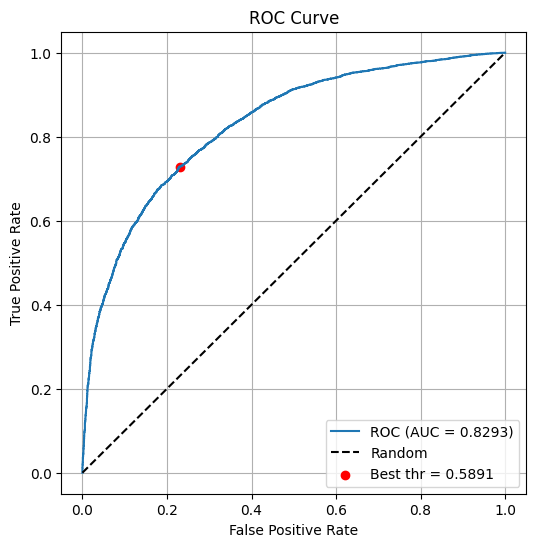

In [32]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt
from scipy.special import expit  # sigmoid

PKL_PATH = "/content/drive/MyDrive/KLTN/result_v15/net-EfficientNetB4_traindb-ff-c23-720-140-140_face-scale_size-224_seed-41_bestval/ff-c23-720-140-140_test.pkl"

df = pd.read_pickle(PKL_PATH)
y_true = df['label'].astype(int).values

y_logit = df['score'].values
y_score = expit(y_logit)

auc = roc_auc_score(y_true, y_score)

fpr, tpr, thresholds = roc_curve(y_true, y_score)
youden_index = tpr - fpr
best_idx = np.argmax(youden_index)
best_threshold = thresholds[best_idx]

y_pred = (y_score >= best_threshold).astype(int)
acc = accuracy_score(y_true, y_pred)

print(f"[AUC]        : {auc:.4f}")
print(f"[Best thr]   : {best_threshold:.4f}")
print(f"[Accuracy]   : {acc:.4f}")

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC (AUC = {auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.scatter(fpr[best_idx], tpr[best_idx], color='red', label=f"Best thr = {best_threshold:.4f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


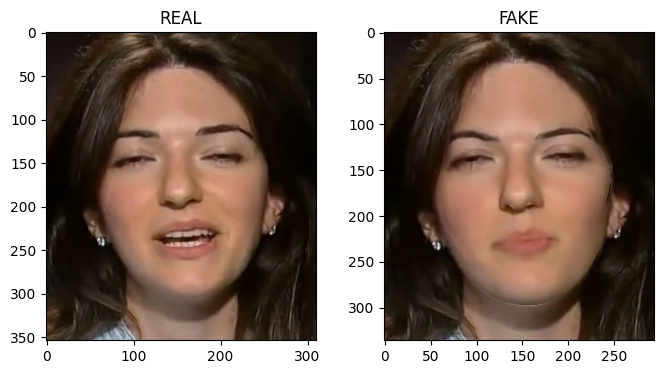

In [39]:
vid_real_faces_1 = face_extractor.process_video('/content/drive/MyDrive/KLTN/datasets/original_sequences/youtube/c23/videos/585.mp4')
vid_fake_faces_1 = face_extractor.process_video('/content/drive/MyDrive/KLTN/datasets/manipulated_sequences/Face2Face/c23/videos/585_599.mp4')
im_real_face_1 = vid_real_faces_1[0]['faces'][0]
im_fake_face_1 = vid_fake_faces_1[0]['faces'][0]
fig,ax = plt.subplots(1,2,figsize=(8,4))

ax[0].imshow(im_real_face_1)
ax[0].set_title('REAL')

ax[1].imshow(im_fake_face_1)
ax[1].set_title('FAKE');

Average score for REAL video: 0.0887 --> Predicted: REAL
Average score for FAKE video: 0.8248 --> Predicted: FAKE


(np.float32(0.088739134), 'REAL', np.float32(0.82476425), 'FAKE')

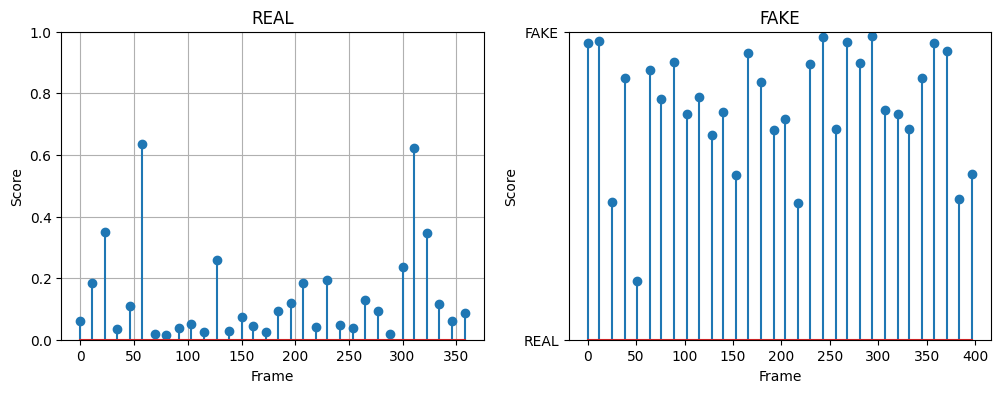

In [40]:
def predict_video_scores(net, vid_real_faces, vid_fake_faces, transf, device, best_threshold=0.5):
    faces_real_t = torch.stack([
        transf(image=frame['faces'][0])['image']
        for frame in vid_real_faces if len(frame['faces'])
    ])
    faces_fake_t = torch.stack([
        transf(image=frame['faces'][0])['image']
        for frame in vid_fake_faces if len(frame['faces'])
    ])

    with torch.no_grad():
        faces_real_pred = net(faces_real_t.to(device)).cpu().numpy().flatten()
        faces_fake_pred = net(faces_fake_t.to(device)).cpu().numpy().flatten()

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    ax[0].stem(
        [f['frame_idx'] for f in vid_real_faces if len(f['faces'])],
        expit(faces_real_pred)
    )
    ax[0].set_title('REAL')
    ax[0].set_xlabel('Frame')
    ax[0].set_ylabel('Score')
    ax[0].set_ylim([0, 1])
    ax[0].grid(True)

    ax[1].stem(
        [f['frame_idx'] for f in vid_fake_faces if len(f['faces'])],
        expit(faces_fake_pred)
    )
    ax[1].set_title('FAKE')
    ax[1].set_xlabel('Frame')
    ax[1].set_ylabel('Score')
    ax[1].set_ylim([0, 1])
    ax[1].set_yticks([0, 1], ['REAL', 'FAKE'])

    score_real_avg = expit(faces_real_pred.mean())
    score_fake_avg = expit(faces_fake_pred.mean())
    pred_real_video = 'FAKE' if score_real_avg >= best_threshold else 'REAL'
    pred_fake_video = 'FAKE' if score_fake_avg >= best_threshold else 'REAL'

    print('Average score for REAL video: {:.4f} --> Predicted: {}'.format(score_real_avg, pred_real_video))
    print('Average score for FAKE video: {:.4f} --> Predicted: {}'.format(score_fake_avg, pred_fake_video))

    return score_real_avg, pred_real_video, score_fake_avg, pred_fake_video
predict_video_scores(net, vid_real_faces_1, vid_fake_faces_1, transf, device, best_threshold=0.5)

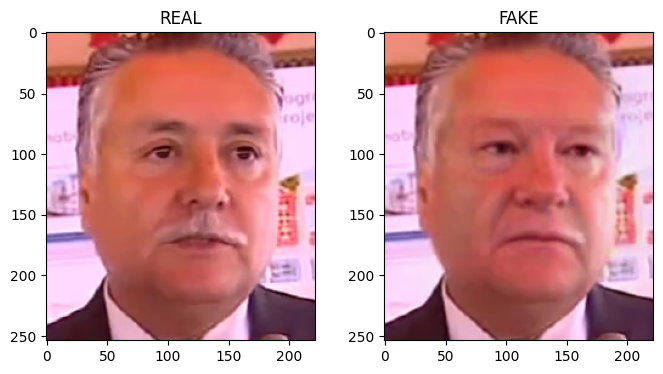

In [47]:
vid_real_faces_2 = face_extractor.process_video('/content/drive/MyDrive/KLTN/datasets/original_sequences/youtube/c23/videos/027.mp4')
vid_fake_faces_2 = face_extractor.process_video('/content/drive/MyDrive/KLTN/datasets/manipulated_sequences/FaceShifter/c23/videos/027_009.mp4')
im_real_face_2 = vid_real_faces_2[0]['faces'][0]
im_fake_face_2 = vid_fake_faces_2[0]['faces'][0]
fig,ax = plt.subplots(1,2,figsize=(8,4))

ax[0].imshow(im_real_face_2)
ax[0].set_title('REAL')

ax[1].imshow(im_fake_face_2)
ax[1].set_title('FAKE');

Average score for REAL video: 0.3289 --> Predicted: REAL
Average score for FAKE video: 0.8753 --> Predicted: FAKE


(np.float32(0.32889396), 'REAL', np.float32(0.8753166), 'FAKE')

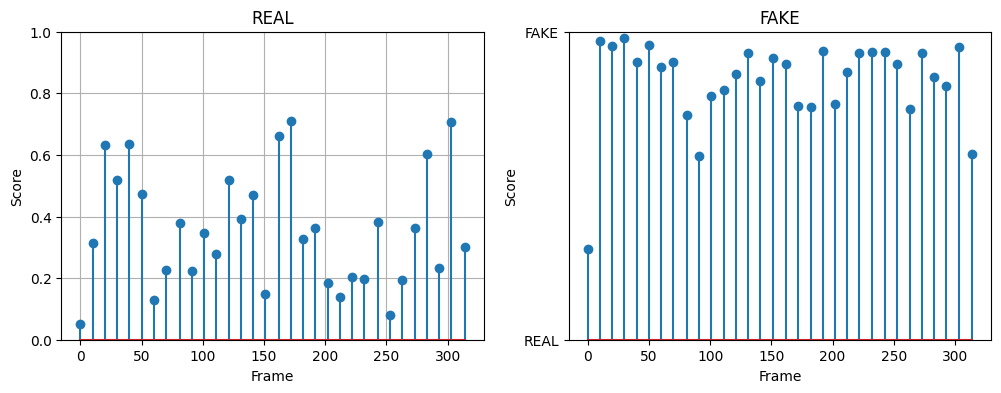

In [48]:
predict_video_scores(net, vid_real_faces_2, vid_fake_faces_2, transf, device, best_threshold=0.5)